# Benchmark: Area computation

Benchmark comparing area computation across:
* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_area-- --out-file ../analysis/benchmark_area/data.json  --iterations 1000
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
        duration.total_ms             
program               geo         geos
count         1000.000000  1000.000000
mean           128.431468   401.843454
std             67.033981   148.565588
min             70.311878   224.463444
25%             72.009595   235.847153
50%             73.404653   475.813517
75%            197.091312   477.407645
max            707.857364  2220.865418


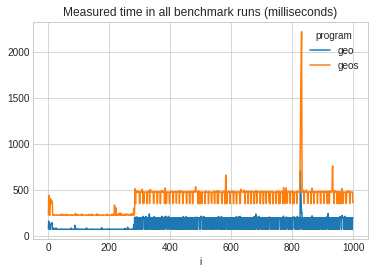

### Statistics: After outlier removal
        duration.total_ms            
program               geo        geos
count          991.000000  991.000000
mean           126.643085  393.628087
std             62.257260  110.386317
min             70.311878  224.463444
25%             72.007568  234.729785
50%             73.343228  475.774231
75%            197.073932  477.355080
max            243.069940  661.566174


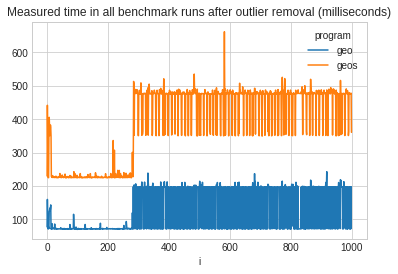

## Absolute difference in runtimes compared to geo
        difference_ms
program          geos
count      991.000000
mean       266.985002
std        104.077227
min         93.163607
25%        154.615567
50%        278.901330
75%        402.892139
max        589.565492


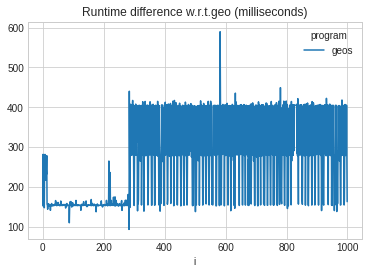

## Relative difference (percent) in runtimes compared to geo
        relative_difference_percent
program                        geos
count                    991.000000
mean                     276.043303
std                      187.224702
min                       46.998940
25%                      141.651443
50%                      212.419425
75%                      550.706350
max                      818.833205


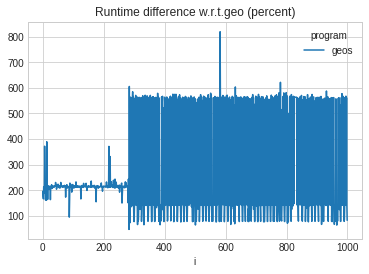

In [4]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb